In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Tentukan jalur direktori untuk data latih, validasi, dan uji
train_data = "../Oprek/Ori_Data_Aug/train" 
val_data = "../Oprek/Ori_Data_Aug/val"
test_data = "../Oprek/Ori_Data_Aug/test"

In [3]:
# Applying Data normalization and Data augmentation
img_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = img_datagen.flow_from_directory(
    train_data,
    batch_size=32,
    color_mode="rgb",
    target_size=(64, 64),
    class_mode="categorical"
)

validation_generator = img_datagen.flow_from_directory(
    val_data,
    batch_size=32,
    color_mode="rgb",
    target_size=(64, 64),
    class_mode="categorical"
)

test_generator = img_datagen.flow_from_directory(
    test_data,
    batch_size=32,
    color_mode="rgb",
    target_size=(64, 64),
    class_mode="categorical"
)

Found 8400 images belonging to 20 classes.
Found 2400 images belonging to 20 classes.
Found 1200 images belonging to 20 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras import regularizers

# Membuat model VGG16
def create_vgg16_model(input_shape=(64, 64, 3),
                              filters=64,
                              # kernel_size=(3, 3),
                              # padding='same', 
                              # activation='relu', 
                              num_classes=20):

    model = Sequential()

    # Blok 1
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Blok 2
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Blok 3
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Blok 4
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Blok 5
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten(name='flatten'))

    # lapisan Dense 1
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.75))

    # lapisan Dense 2
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.75))

    model.add(Dense(num_classes, activation='softmax'))

    # Adam optimizer with learning rate scheduling and gradient clipping
    opt = Adam(learning_rate=0.001, clipvalue=0.5)  # Gradient clipping
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Membuat model VGG16
model = create_vgg16_model()

# Menampilkan ringkasan model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                        

In [5]:
# Fungsi untuk menetapkan learning rate secara dinamis
def lr_scheduler(epoch, lr):
    if epoch % 15 == 0 and epoch > 0:
        lr = lr * 0.9  # Contoh: Mengurangi learning rate setiap 10 epoch
    return lr

# Fungsi untuk menghentikan pelatihan jika akurasi mencapai 95%
class AccuracyThreshold(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.95:
            print("\nAkurasi mencapai 95%! Menghentikan pelatihan.")
            self.model.stop_training = True

In [6]:
# Menambahkan learning rate scheduler dan early stopping
lr_schedule = LearningRateScheduler(lr_scheduler)
accuracy_threshold = AccuracyThreshold()
callbacks_list = [lr_schedule, accuracy_threshold]

In [7]:
# Train the model with EarlyStopping callback
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks_list  # Menggunakan callbacks_list yang sudah termasuk EarlyStopping
)

Epoch 1/20
263/263 [==============================] - 2443s 9s/step - loss: 4.0673 - accuracy: 0.1748 - val_loss: 12.4975 - val_accuracy: 0.0500 - lr: 0.0010
Epoch 2/20
263/263 [==============================] - 2375s 9s/step - loss: 2.0122 - accuracy: 0.5276 - val_loss: 2.8093 - val_accuracy: 0.2642 - lr: 0.0010
Epoch 3/20
263/263 [==============================] - 2718s 10s/step - loss: 1.2071 - accuracy: 0.7701 - val_loss: 0.7244 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 4/20
263/263 [==============================] - 2428s 9s/step - loss: 0.8237 - accuracy: 0.8836 - val_loss: 0.6424 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 5/20
263/263 [==============================] - 2886s 11s/step - loss: 0.6568 - accuracy: 0.9164 - val_loss: 0.4363 - val_accuracy: 0.9596 - lr: 0.0010
Epoch 6/20
263/263 [==============================] - 2794s 11s/step - loss: 0.5072 - accuracy: 0.9443 - val_loss: 0.4115 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 7/20
263/263 [==============================] - 

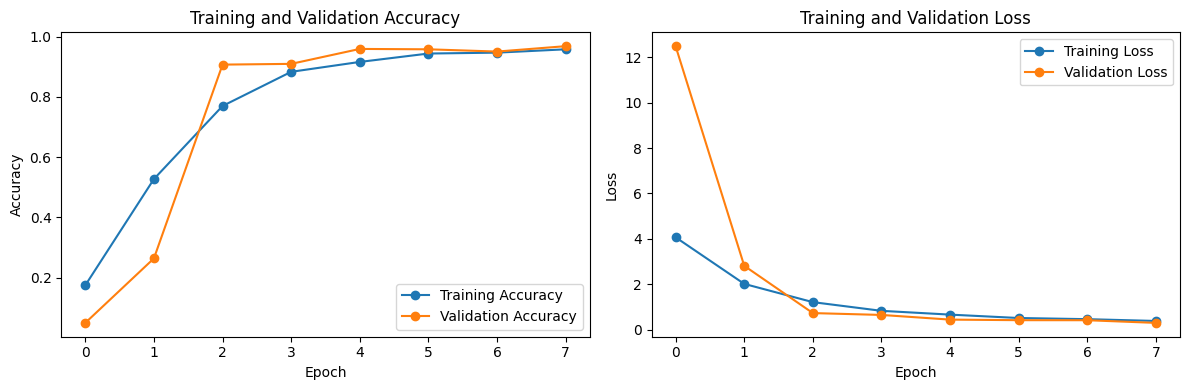

In [8]:
# Menampilkan grafik training dan validation accuracy
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [9]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

38/38 [==============================] - 201s 5s/step - loss: 0.2685 - accuracy: 0.9750
Test Accuracy: 97.50%


In [27]:
# Simpan model setelah pelatihan
model.save('../Oprek/example_model.h5')

In [38]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt  # Make sure to import plt for displaying the image
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
    # Predicting images
    path = fn
    img = image.load_img(path, target_size=(150, 150))  # Adjust target_size if needed
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)

    print(fn)
    # Assuming the model has 20 classes
    if classes[0, 0] != 0:
        print('ba')
    elif classes[0, 1] != 0:
        print('ca')
    elif classes[0, 2] != 0:
        print('da') 
    elif classes[0, 3] != 0:
        print('dha')
    elif classes[0, 4] != 0:
        print('ga')
    elif classes[0, 5] != 0:
        print('ha')
    elif classes[0, 6] != 0:
        print('ja')
    elif classes[0, 7] != 0:
        print('ka')
    elif classes[0, 8] != 0:
        print('la')
    elif classes[0, 9] != 0:
        print('ma')
    elif classes[0, 10] != 0:
        print('na')
    elif classes[0, 11] != 0:
        print('nga')
    elif classes[0, 12] != 0:
        print('nya')
    elif classes[0, 13] != 0:
        print('pa')
    elif classes[0, 14] != 0:
        print('ra')
    elif classes[0, 15] != 0:
        print('sa')
    elif classes[0, 16] != 0:
        print('ta')
    elif classes[0, 17] != 0:
        print('tha')
    elif classes[0, 18] != 0:
        print('wa')
    elif classes[0, 19] != 0:
        print('ya')
    else:
        print('Unknown Class')

ModuleNotFoundError: No module named 'google.colab'

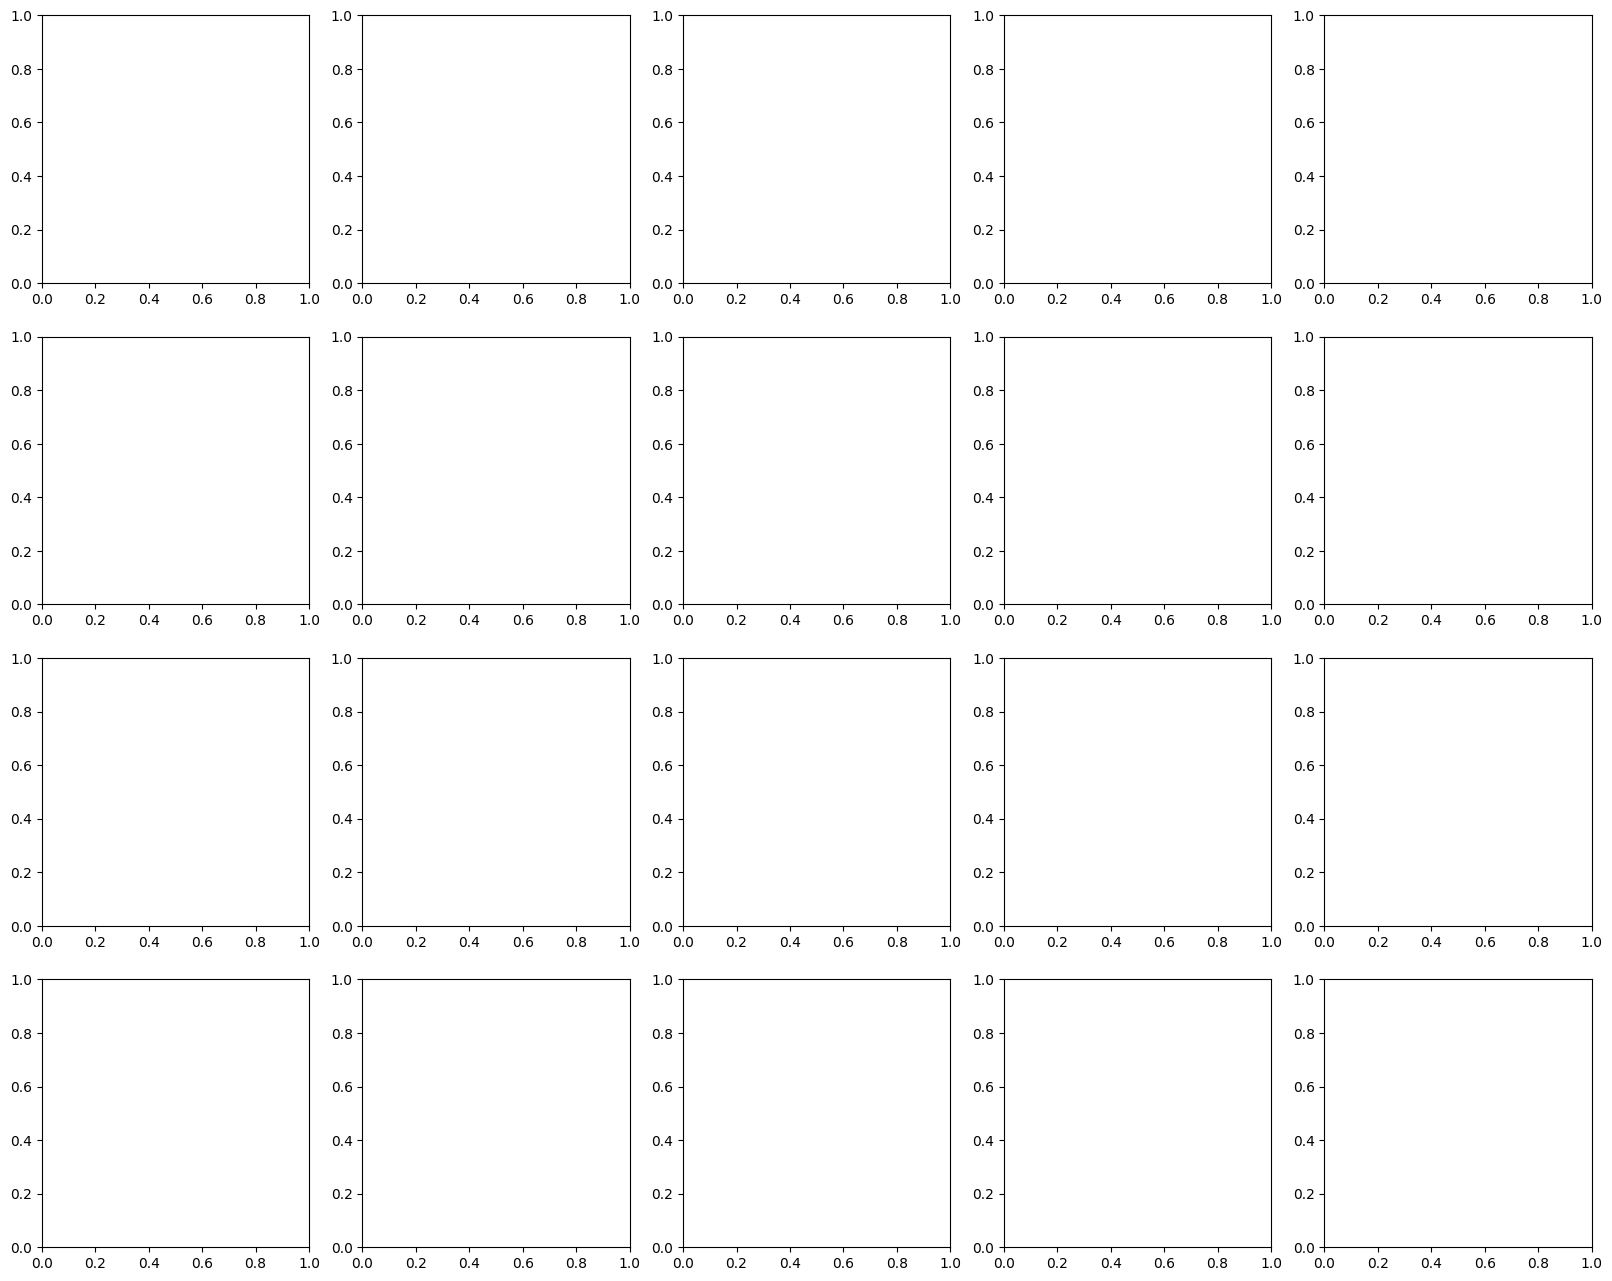

In [33]:
import matplotlib.pyplot as plt

loaded_model = tf.keras.models.load_model('../Oprek/example_model.h5')

# Fungsi untuk mengonversi label karakter ke kategori
def label2cat(label):
    # Tambahkan logika sesuai dengan karakter label Anda
    # Contoh sederhana: 'ba' -> "Kategori ba", 'ca' -> "Kategori ca", dst.
    return f"Kategori {label}"

# Mendefinisikan beberapa dummy data (gantilah dengan data sesungguhnya)
feature = []  # List berisi data gambar
target = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']  # Label dummy
preds = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']  # Hasil prediksi dummy

# Membuat subplots
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

# Iterasi melalui data dan menggambar gambar serta menambahkan label
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat(label), label2cat(pred)
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font)
    ax.axis("off")

plt.show()

In [31]:
# import tensorflow as tf
# import matplotlib.pyplot as plt
  
# # Step 3: Lakukan prediksi menggunakan model yang telah disimpan
# # Assume test_dataset is your test dataset containing images and labels
# loaded_model = tf.keras.models.load_model('../Oprek/example_model.h5')


# # Collect one image for each class
# unique_labels = set()
# images_by_class = {}

# for images, labels in test_generator:
#     for i in range(len(images)):
#         # label = labels[i].numpy()
#         label = labels[i]
#         if label not in unique_labels:
#             unique_labels.add(label)
#             # images_by_class[label] = images[i].numpy()  # Konversi ke NumPy array
#             images_by_class[label] = images[i] 

# # Make predictions for the collected images
# for label, image in images_by_class.items():
#     # Expand dimensions to match the model's input shape
#     image = tf.expand_dims(image, axis=0)
    
#     # Predict the class probabilities
#     predictions = model.predict(image)

#     # Display the image, true label, and predicted label
#     plt.figure(figsize=(6, 6))
#     plt.imshow(image[0])
#     # plt.title(f"True Label: {label}, Predicted Label: {tf.argmax(predictions[0]).numpy()}")
#     plt.title(f"True Label: {label}, Predicted Label: {tf.argmax(predictions[0])}")
#     plt.show()

TypeError: unhashable type: 'numpy.ndarray'